# Introduction 🚦


This notebook allows you to explore a fundamental part of the architecture of voice recognition and generation models – encoding.  Encoding is a process that turns data from one form to another, in this case from an audio signal to spectrogram. 

In [ ]:
# Running this cell will load all of the libraries needed for this document.

!pip install ffmpeg-python

import ffmpeg
import IPython.display as ipd
from IPython.display import HTML, Audio
import librosa, librosa.display
import scipy
import matplotlib.pyplot as plt
from google.colab.output import eval_js
from google.colab import files
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
from PIL import Image
import soundfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Spectrograms 🖼


Rather than taking audio as an input, modern machine learning systems use spectrograms to represent the audio signal in a manner that is amenable to computer vision - a 2-Dimensional image. 



### Loading sounds and plotting spectrograms

#### Recording Samples

If you'd like to record your own samples for this we recommend a minimum of 10. We'd recommend using excerpts from the [Crip Tech Manifesto](https://journals.scholarsportal.info/pdf/23803312/v05i0001/1_ctm.xml) as a script to create this data.

Make sure to rename each sample after recording so you know which is which.

If you have chosen to use the Common Voice dataset make sure to edit the path and the filetype to reflect this where appropriate (e.g. /content/audio/sample-000000.mp3)


In [ ]:
#@title Prep for recording 🎧
# Method is from https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=57xW3GSb6gv0 , only edited button messages


AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Press to stop recording";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
#@title Record your audio 🎤
from datetime import datetime
audio, sr = get_audio()

# save the audio
scipy.io.wavfile.write('recording' + datetime.now().strftime("%H%M%S") + '.wav', sr, audio)

To check through your samples without downloading them follow the template set below. `ipd.display(ipd.Audio('/path/to/audio.wav'))`

In [ ]:
# Load sounds
sample1, sr = librosa.load('/content/recording081206.wav')

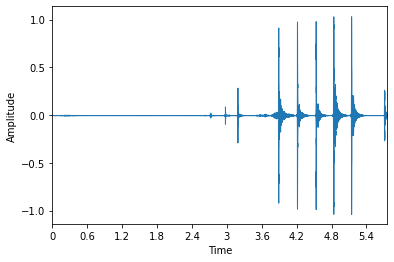

In [ ]:
#@title Show Waveform
# Show waveform
signal, sr = librosa.load('/content/recording081206.wav', sr=22050)
librosa. display. waveplot (signal, sr=sr) 
plt.xlabel("Time") 
plt.ylabel("Amplitude") 
plt.show( )

### Transform

This following cell transforms your audio waveform to a spectrogram. 

Spectrograms are composed on two frequency scales, either MEL scaled – which represents the signal with respect to our perception of pitch – or BARK scaled— which reflects our subjective perception of loudness, with greater emphasis on lower frequencies. The MEL scale is a logarithmic transformation of a signal's frequency, representing the fact that sounds equidistant from one another on the MEL scale are perceived to be equidistant by humans. We tend to be more adept at noticing differences at lower frequencies than higher ones. 

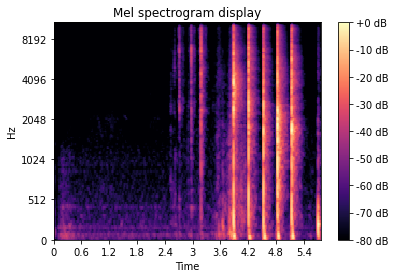

In [ ]:
#@title Generate mel spectrogram 🖼️
y, sr = librosa.load('/content/recording081206.wav')

D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=y, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")

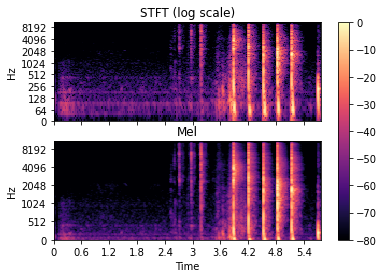

In [ ]:
# Construct a subplot grid with 3 rows and 1 column, sharing the x-axis)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

# On the first subplot, show the original spectrogram
img1 = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='STFT (log scale)')

# On the second subplot, show the mel spectrogram
img2 = librosa.display.specshow(M_db, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Mel')

# To eliminate redundant axis labels, we'll use "label_outer" on all subplots:
for ax_i in ax:
    ax_i.label_outer()

# And we can share colorbars:
fig.colorbar(img1, ax=[ax[0], ax[1]])

# Formant Analysis with Praat-Parselmouth 🐍

Once we have our spectrograms we're able to treat the encoded audio signal to all sorts of forms of analysis. Here we have an implementation of Praat: an open source tool commonly used in the field of Phonetics to analyse speech signals and visualise characteristic features such as pitch and formants.

The purpose of this section is to encourage us to think expansively about the role formant analysis plays in the construction of identity. How it relates to the body, conditions expectations, and how we might subvert it. 

In [ ]:
pip install praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.7 MB 5.3 MB/s 


In [ ]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from IPython.display import Audio, display
from IPython.display import HTML

You can either use the audio files you have just recorded or use the reduced [Common Voice](https://commonvoice.mozilla.org/) dataset we have provided. 

We have automatically created a folder called `audio` in your sidebar, if you choose to rename this you will need to make sure that your paths are still correct when running the following cells.

In [ ]:
# Show Sounds
ipd.display(ipd.Audio('/content/recording081206.wav'))

<Figure size 432x288 with 0 Axes>

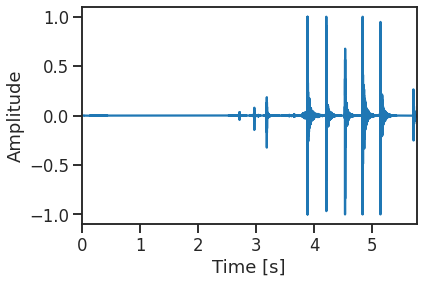

In [ ]:
#Set styles
sns.set_style("ticks")
sns.despine()
sns.set_context("talk")

# Define sounds
sample1 = parselmouth.Sound("/content/recording081206.wav")

# Plot the chart
plt.figure()
plt.plot(sample1.xs(), sample1.values.T)
plt.xlim([sample1.xmin, sample1.xmax])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Draw Spectrogram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


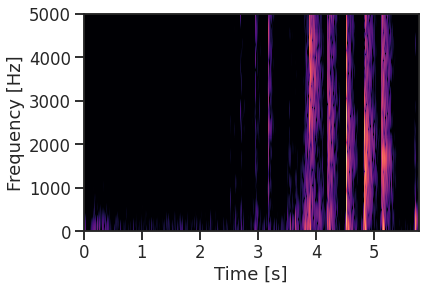

In [ ]:
# Draw a spectrogram of the input file

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='magma')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])

# Label your axes    
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")

# Draw it
spectrogram = sample1.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.xlim([sample1.xmin, sample1.xmax])
plt.show()


## Draw Pitch

Plotting pitch on this spectrogram will give you a sense of where your fundamental frequency sits for certain vowel sounds. 

Analyse your formants, have a look at some of the resources on the Figjam board and explore the ways in which your vocal signal might be construed and constrained.

See if you can articulate differently to change these. How does the interaction between frequency and formant analysis condition wider systems of classification and prediction? If you can reliably change these, how effective are they in recognition scenarios?

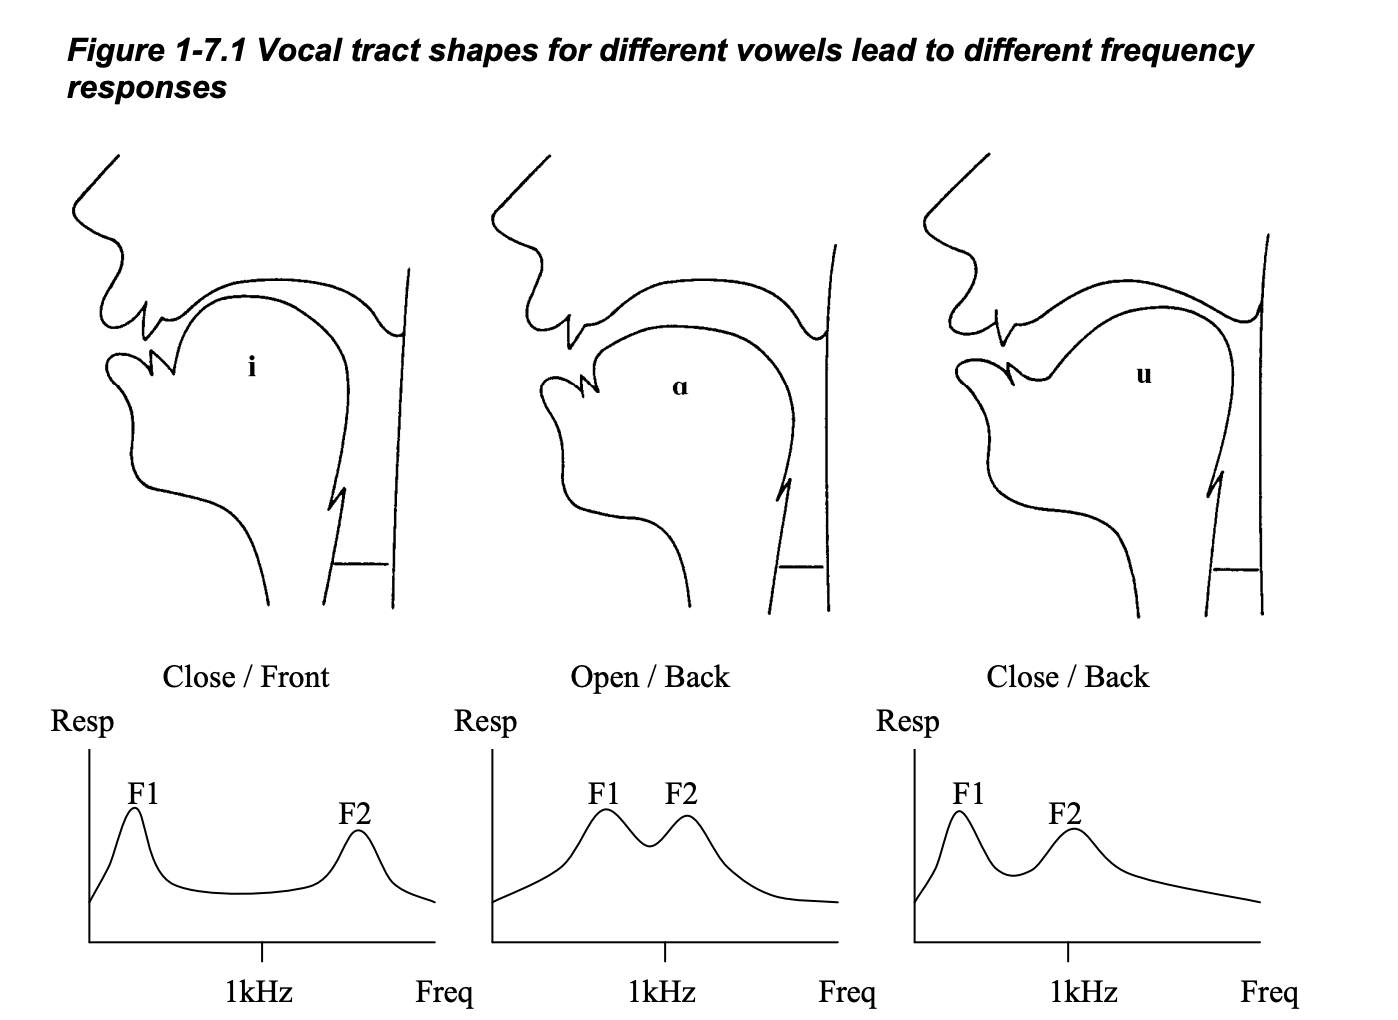

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


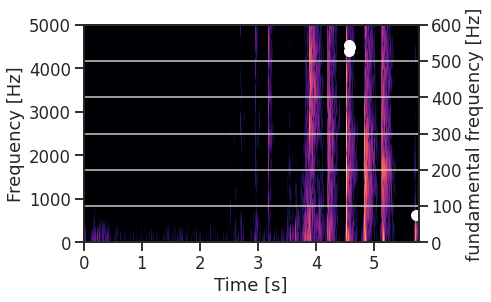

In [ ]:
def draw_pitch(pitch):
    # Extract pitch contour
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=10, color='w')
    plt.grid(True)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = sample1.to_pitch()

# Draw Spectrogram
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([sample1.xmin, sample1.xmax])
plt.show()